In [1]:
##imports bit messy 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, zero_one_loss
from sklearn.metrics import zero_one_loss, make_scorer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.base import clone, BaseEstimator
from dataclasses import dataclass, field
from typing import List, Any, Optional
from sklearn.pipeline import Pipeline

#disable warnings

import warnings
warnings.filterwarnings('ignore')


In [2]:
def read_abalone_data() -> pd.DataFrame:
    #load data
    column_names = [
        "sex",
        "length",
        "diameter",
        "height",
        "whole_weight",
        "shucked_weight",
        "viscera_weight",
        "shell_weight",
        "rings"
    ] 
    df = pd.read_csv("data/abalone.data", names=column_names)
    return df

def preproces_data(df: pd.DataFrame) -> pd.DataFrame:
    amount_of_removed_datapoints = 0
    initial_dataframe_length = len(df)
    df = df[df['height'] != 0]
    df = df[df['height'] < 0.4]
    df = df[(df["whole_weight"] - df["shucked_weight"] - df["viscera_weight"] - df["shell_weight"]) > 0]  
    print(f"removed {initial_dataframe_length - len(df)} data points")
    return df

def get_data() -> (pd.DataFrame, pd.Series):
    df = read_abalone_data()
    df = preproces_data(df)
    y_regression = df["rings"]
    y_classification = df["rings"].apply(lambda rings: "young" if rings <=8 else ("medium" if rings <= 10 else "old"))
    X = df.drop(columns=["rings"])
    X = pd.get_dummies(X, columns=['sex', ])
    return X, y_regression, y_classification

In [3]:
X, y_regression, _ = get_data()

removed 161 data points


The task is a bit senseless for our dataset, as parameter optimisation in this case is to combat overfitting. Our model does not overfit at all though.

In [22]:
def cross_validate_model(model, lossfn, param_name, param, X_train, y_train):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    model = clone(model)
    params = {param_name: param}
    scalar = StandardScaler()
    model.set_params(**params)
    pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
    #model = Ridge(alpha)
    scores = cross_validate(pipeline, X_train, y_train, cv=kf, scoring=lossfn, return_train_score=True)
    return -scores['train_score'].mean(), -scores['test_score'].mean()


def test_params(model, lossfn, X, y, param_name, params):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
    #normalise data
        
    #r_alphas = np.logspace(-7, 3, 200) 
    performance = []
    for p in params:
        train_err, test_err = cross_validate_model(model, lossfn, param_name, p, X_train, y_train)
        performance.append({
            "param": p if not isinstance(p, tuple) else p[0],
            "train_error": train_err,
            "test_error": test_err
        })
    return pd.DataFrame(performance)

In [23]:
X, _, y_classification = get_data()

zero_one_scorer = make_scorer(zero_one_loss, greater_is_better=False)
scoring={'score': zero_one_scorer, 'accuracy': 'accuracy'}
h_scores_classification = test_params(MLPClassifier(), scoring, X, y_classification, "hidden_layer_sizes", range(10, 300, 10))
h_scores_classification

removed 161 data points


,param,train_error,test_error
0,10,0.329874,0.345567
1,20,0.322679,0.334992
2,30,0.320880,0.336862
3,40,0.320154,0.335305
4,50,0.319289,0.336866
5,60,0.317490,0.339035
6,70,0.316072,0.339660
7,80,0.316037,0.334992
8,90,0.315864,0.334680
9,100,0.314342,0.341221


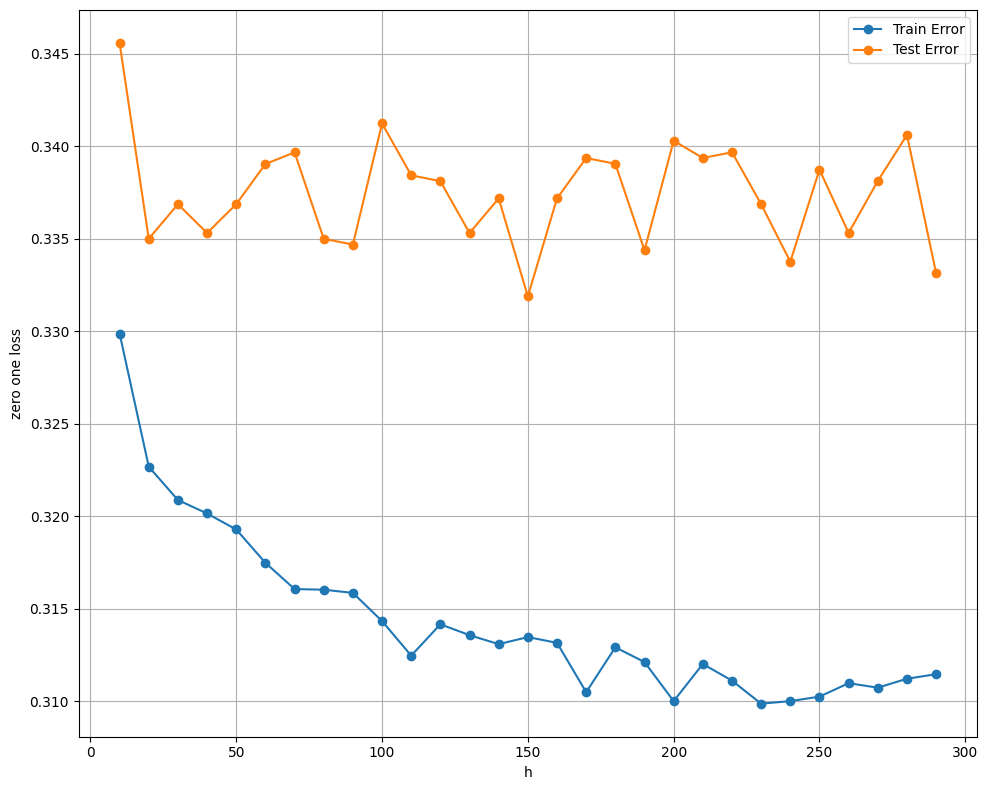

In [24]:
plt.figure(figsize=(10, 8))  
plt.plot(h_scores_classification["param"], h_scores_classification["train_error"], label="Train Error", marker="o")
plt.plot(h_scores_classification["param"], h_scores_classification["test_error"], label="Test Error", marker="o")

plt.xlabel("h")
plt.ylabel("zero one loss")
plt.legend()
plt.grid(True)

plt.tight_layout() 

plt.show()


In [27]:
X, y_regression, _ = get_data()

h_scores_regression = test_params(MLPRegressor(), "neg_mean_squared_error", X, y_regression, "hidden_layer_sizes", range(10, 300, 10))
h_scores_regression


removed 161 data points


,param,train_error,test_error
0,10,4.867882,4.939418
1,20,4.635442,4.760868
2,30,4.546707,4.685134
3,40,4.461265,4.609416
4,50,4.424749,4.593267
5,60,4.387705,4.574944
6,70,4.343498,4.546730
7,80,4.323452,4.524117
8,90,4.309370,4.507771
9,100,4.282526,4.495754


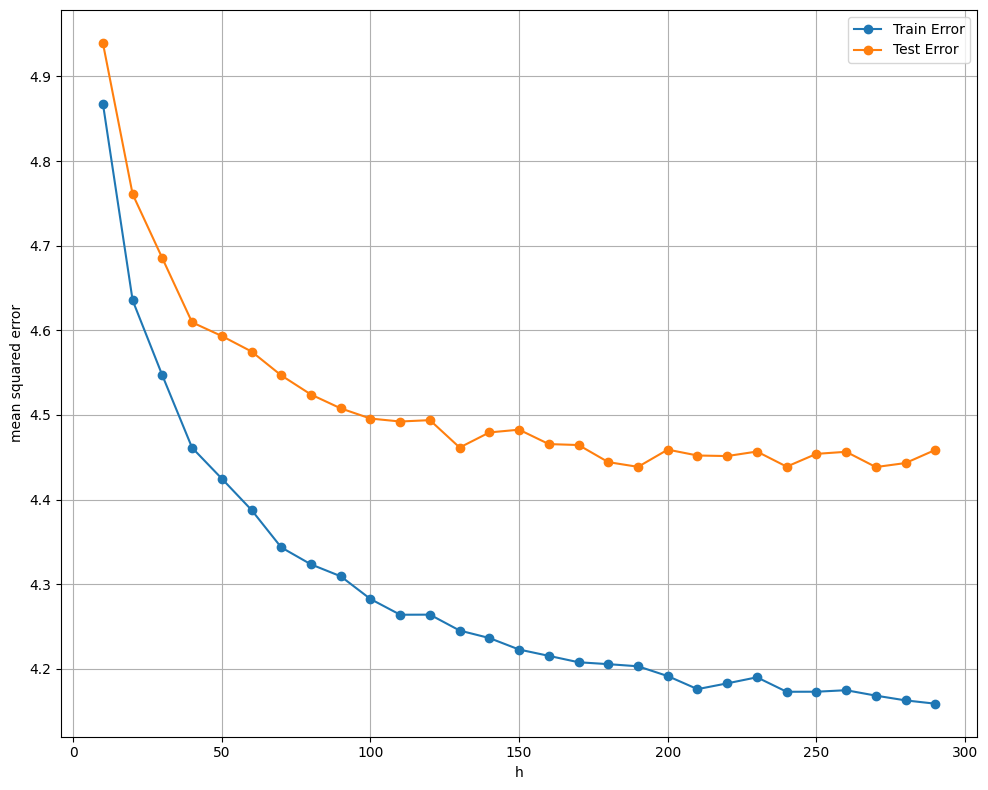

In [28]:
plt.figure(figsize=(10, 8))  
plt.plot(h_scores_regression["param"], h_scores_regression["train_error"], label="Train Error", marker="o")
plt.plot(h_scores_regression["param"], h_scores_regression["test_error"], label="Test Error", marker="o")

plt.xlabel("h")
plt.ylabel("mean squared error")
plt.legend()
plt.grid(True)

plt.tight_layout() 

plt.show()


In [30]:
X, _, y_classification = get_data()
zero_one_scorer = make_scorer(zero_one_loss, greater_is_better=False)
scoring={'score': zero_one_scorer, 'accuracy': 'accuracy'}
c_scores = test_params(LogisticRegression(), scoring, X, y_classification, "C", np.logspace(-7, 3, 200) )
c_scores


removed 161 data points


,param,train_error,test_error
0,1.000000e-07,0.647572,0.647571
1,1.122668e-07,0.647572,0.647571
2,1.260383e-07,0.647572,0.647571
3,1.414991e-07,0.647572,0.647571
4,1.588565e-07,0.647572,0.647571
...,...,...,...
195,6.294989e+02,0.338557,0.343084
196,7.067181e+02,0.338730,0.343395
197,7.934097e+02,0.338660,0.343395
198,8.907355e+02,0.338695,0.343395


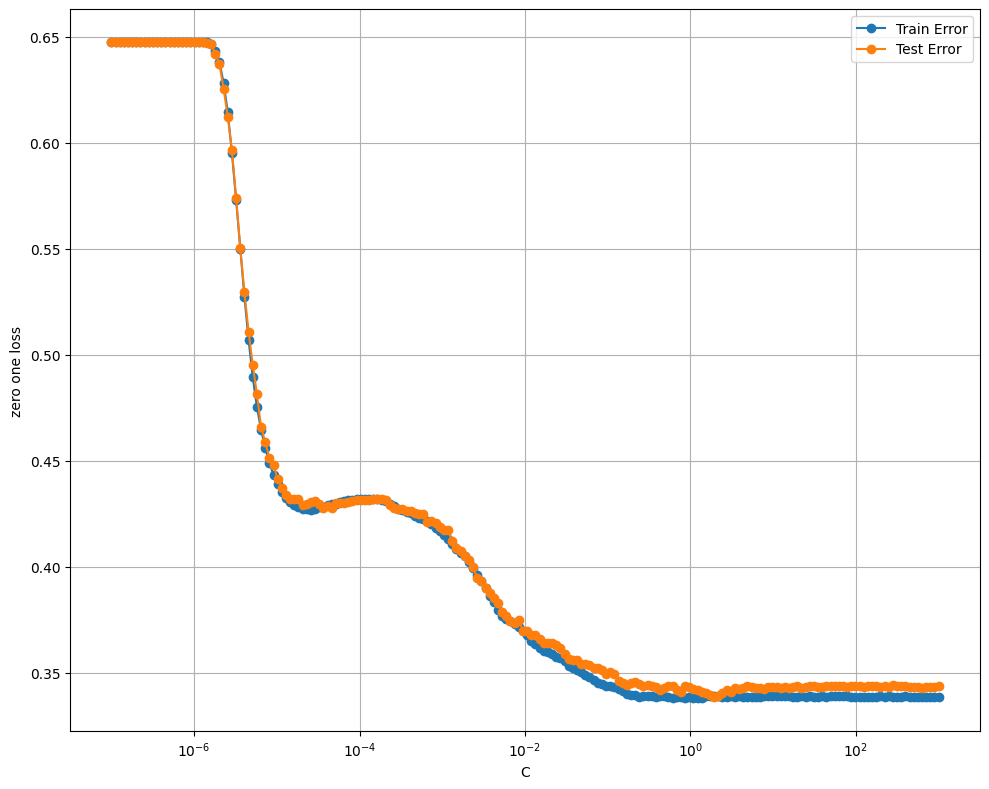

In [31]:
plt.figure(figsize=(10, 8))  
plt.semilogx(c_scores["param"], c_scores["train_error"], label="Train Error", marker="o")
plt.semilogx(c_scores["param"], c_scores["test_error"], label="Test Error", marker="o")

plt.xlabel("C")
plt.ylabel("zero one loss")
plt.legend()
plt.grid(True)

plt.tight_layout() 

plt.show()


In [39]:
X, y_regression, _ = get_data()
alpha_scores = test_params(Ridge(), "neg_mean_squared_error", X, y_regression, "alpha", np.logspace(-7, 3, 200) )
alpha_scores


removed 161 data points


,param,train_error,test_error
0,1.000000e-07,4.766147,4.823147
1,1.122668e-07,4.766147,4.823147
2,1.260383e-07,4.766147,4.823147
3,1.414991e-07,4.766147,4.823147
4,1.588565e-07,4.766147,4.823147
...,...,...,...
195,6.294989e+02,5.717351,5.738550
196,7.067181e+02,5.785263,5.805557
197,7.934097e+02,5.854311,5.873739
198,8.907355e+02,5.924021,5.942619


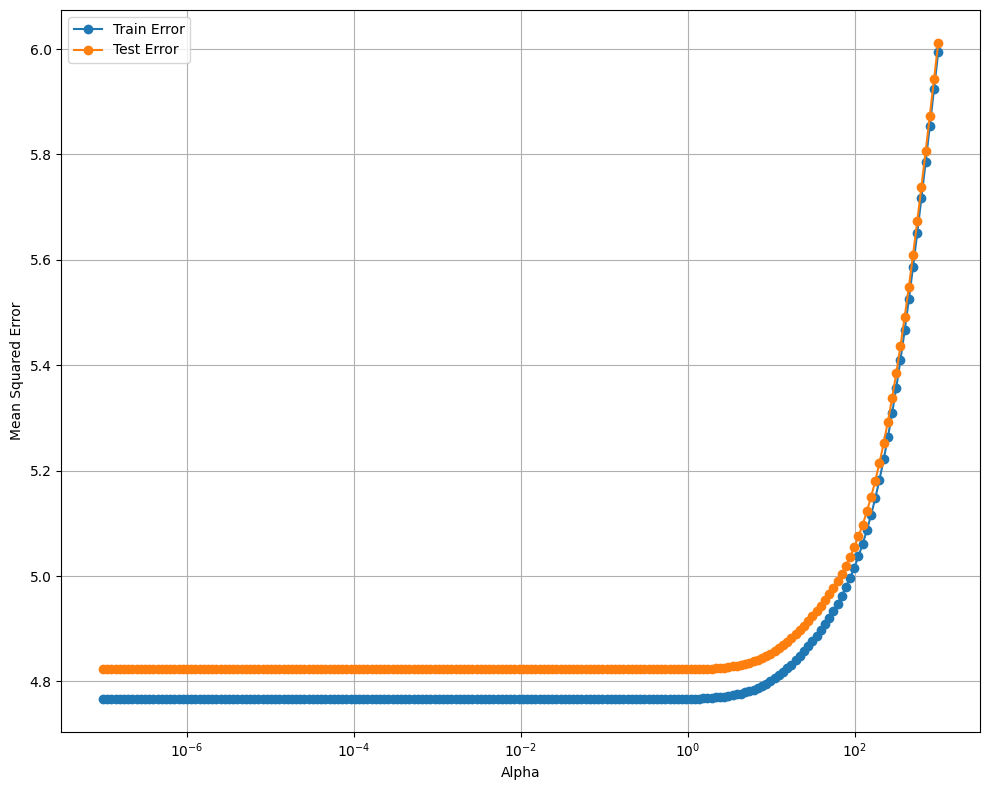

In [40]:
plt.figure(figsize=(10, 8))  
plt.semilogx(alpha_scores["param"], alpha_scores["train_error"], label="Train Error", marker="o")
plt.semilogx(alpha_scores["param"], alpha_scores["test_error"], label="Test Error", marker="o")

plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
#plt.title("Ridge Regression: Train vs Test Error across α values")
plt.legend()
plt.grid(True)

plt.tight_layout() 
plt.savefig("images/project2/linear_regression_alpha_search.png")

plt.show()


[  0.92449034   7.61552315  19.27300223  10.15350963 -21.38309917
 -11.78363171   6.8017569    0.24401207  -0.582972     0.33895993]
3.403785014297304


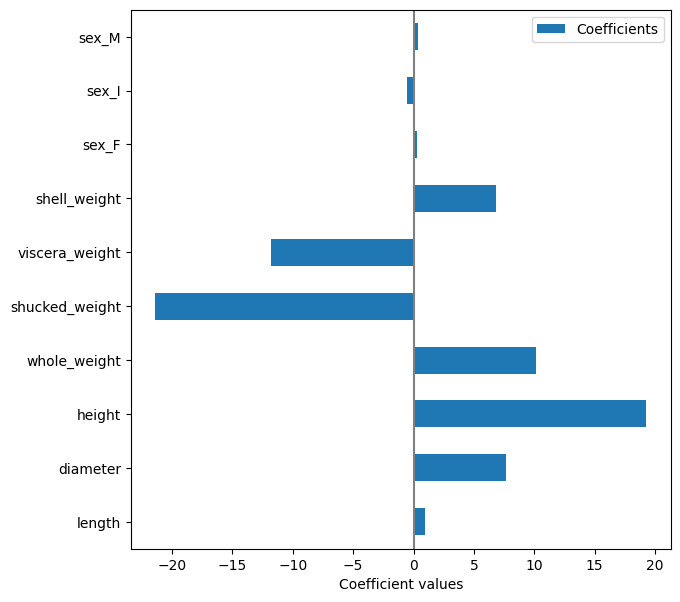

In [38]:
from sklearn.model_selection import train_test_split
X, y_regression, _ = get_data()

X_train, X_test, y_train, y_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=1
)
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)
coefficients = model.coef_
intercept = model.intercept_

print(coefficients)
print(intercept)

feature_names = X_train.columns

coefs = pd.DataFrame(
    model.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs.plot.barh(figsize=(9, 7))
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient values")
plt.subplots_adjust(left=0.3)
plt.savefig("images/project2/lin_reg_coefs.png")


In [39]:
print(X_train.head())
print(y_train.head())

      length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
3620   0.640     0.500   0.170        1.2645          0.5650          0.3375   
2310   0.435     0.350   0.110        0.3840          0.1430          0.1005   
1865   0.520     0.380   0.115        0.6645          0.3285          0.1700   
352    0.570     0.460   0.140        0.9535          0.4465          0.2065   
3625   0.670     0.525   0.195        1.4200          0.5730          0.3680   

      shell_weight  sex_F  sex_I  sex_M  
3620        0.3150   True  False  False  
2310        0.1250   True  False  False  
1865        0.1425  False   True  False  
352         0.2450  False  False   True  
3625        0.3905   True  False  False  
3620     9
2310    13
1865     7
352     12
3625    10
Name: rings, dtype: int64


From the book:
This also holds in general: When the regularization λ is small, the models have high variance
and low bias. When λ is large, the models have low variance (they are all dragged towards the
x-axis) but high bias. As a rule, varying λ to search for an optimal value of the generalization error
will therefore lead to better models. In fig. 14.3 the variable λ is tweaked from a very small value
of λ = 10−6 to a higher value λ = 100 and the training and test error (normalized by the number
of observations) of the small dataset in fig. 14.1 displayed. The three particular values plotted in
fig. 14.1 are plotted as circles. We see that the training error generally increases as λ increases (after
all, for small λ the model will overfit the training data set), however, the test error has an optimum
when λ ≈ 10−2. In practice when we search for the optimal value of λ, we test S different values
of λ, λ1, . . . , λS selected beforehand and then compare each of the corresponding linear regression
models using cross-validation for model selection.

In [40]:
#class BaselineLinearRegression(LinearRegression):
#    def predict_baseline(self, y_train, y_test):
#        self.fit(X=np.zeros((len(y_train), 1)), y=y_train)  
#        return self.predict(np.zeros((len(y_test), 1)))

@dataclass
class Hyperparameter:
    name: str
    values: list
    table_name: str
    best_value: Optional[Any] = None 


@dataclass
class CrossValidationScore:
    fold: int
    score: float
    best_hyperparameters: list[Hyperparameter]  ##bit dumb and dublicated but cant think right now
    ##might need a a to_str()

@dataclass
class Model: ##TODO shit name - not just the model
    name: str
    model: BaseEstimator
    hyperparameters: dict = None,
    scores: list[CrossValidationScore] = field(default_factory=list)

def grid_search(X, y, model, inner_cv, param_grid):
    gs = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=inner_cv, n_jobs=2
    )
    best_model = gs.fit(X, y)
    return gs.best_params_, best_model
    

def normalise(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    return X_train_scaled, X_test_scaled


def train_models(X, y, models: list[Model], loss_fn):
    outer_cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]   
        for model in models:
            model.model = clone(model.model)

            step_name = 'model' 
            pipe = Pipeline([
                ('scale', StandardScaler()),
                (step_name, model.model),
            ])
            
            if model.hyperparameters:
                ##sklearn pipeline expects the parameters to be preficed by Pipeline step name
                ## eg. model__C instead of just C 
                param_grid: Dict[str, List[Any]] = {
                    f'{step_name}__{hp.name}': hp.values
                    for hp in model.hyperparameters
                }

                gs = GridSearchCV(
                    estimator=pipe, param_grid=param_grid, cv=inner_cv, n_jobs=2
                )
                gs.fit(X_train, y_train)
                best_params = gs.best_params_ 
                best_model = gs.best_estimator_ 
                
                best_hyperparams = copy.deepcopy(model.hyperparameters)
                hyperparameter_map: Dict[str, Hyperparameter] = {hp.name: hp for hp in best_hyperparams}
                for p, v in best_params.items():
                    # Un-prefix the parameter name before mapping back to Hyperparameter objects
                    original_param_name = p.split('__')[-1] 
                    hyperparameter_map[original_param_name].best_value = v
            else:
                best_hyperparams = None
                best_model = model.model
                best_model.fit(X_train, y_train)
            
            y_pred = best_model.predict(X_test)   
   
            model.scores.append(
                CrossValidationScore(
                    fold=fold, 
                    score=loss_fn(y_test, y_pred),
                    best_hyperparameters=best_hyperparams
                )
            )
    

In [64]:
def is_float(element: any) -> bool:
    #If you expect None to be passed:
    if isinstance(element, tuple):
        return False
    if element is None: 
        return False
    try:
        float(element)
        return True
    except ValueError:
        return False


def generate_hyperparameter_latex_table(models: List[Model], score_precision: int = 1) -> str:
    number_of_models = len(models)
    total_cols = 1 + number_of_models  
    column_format = '|c' # Start with '|c' for the 'i' column
    model_header_row = [r'\multicolumn{1}{|c|}{Outer fold}']
    sub_header_row = [r'$i$'] 
    total_subcolums = 1 #baseline
    data_rows = []
    
    for model in models:
        amount_of_subcolumns = len(model.hyperparameters) + 1 if model.hyperparameters else 1
        model_column_format = "c" * amount_of_subcolumns
        column_format += '|' + model_column_format
        model_header_row.append(r'\multicolumn{' + str(amount_of_subcolumns) + r'}{c|}{' + model.name + '}')

        if model.hyperparameters:
            for param in model.hyperparameters:
                sub_header_row.append('$' + param.table_name + '$') 
                total_subcolums += 1
        sub_header_row.append(r'$E_i^{\text{test}}$')
        total_subcolums += 1     
     
        for score in model.scores:
            if score.fold > len(data_rows): 
                data_rows.append([str(score.fold)])

            if score.best_hyperparameters:
                for param in score.best_hyperparameters:
                    if isinstance(param.best_value, tuple): ##only do as long as we dont use hidden layers or other tuple params
                        best_value = str(param.best_value[0])
                    else:
                        best_value = str(param.best_value) if param.best_value else ""
                    if is_float(param.best_value):
                        best_value = f"{param.best_value:.{score_precision}f}"
                    data_rows[score.fold - 1].append(best_value)
            
            formatted_score = f"{score.score:.{score_precision}f}"
            data_rows[score.fold - 1].append(formatted_score)
            
    column_format += '|'   
        
    latex_code = []
    latex_code.append(r'\begin{table}')
    latex_code.append(r'\centering')
    latex_code.append(r'\begin{tabular}{' + column_format + r'}')
    latex_code.append(r'\toprule')
    latex_code.append(' & '.join(model_header_row) + r' \\')

    latex_code.append(r'\cmidrule{2-' + str(total_subcolums) + '}') 
    latex_code.append(' & '.join(sub_header_row) + r' \\')
    latex_code.append(r'\midrule')

    for row in data_rows:      
        latex_code.append(' & '.join(row) + r' \\')

    latex_code.append(r'\bottomrule')
    latex_code.append(r'\end{tabular}')
    latex_code.append(r'\end{table}')

    print('\n'.join(latex_code))

In [62]:
##above class definitions are shit
##which makes this waaaaaaaaaaaaaaaayyyy to complicated or i am just to tired
## dont care enough to fix this right now

import copy
import numbers
from collections import defaultdict, Counter
from typing import Any, List, Optional

def _get_final_best_value(values: list[Any]) -> Any:
    is_numerical = all(isinstance(v, numbers.Number) for v in values)

    if is_numerical:
        return sum(values) / len(values)
    else:
        return Counter(values).most_common(1)[0][0]

def get_average_best_model(models: list['Model']) -> list['Model']:
    final_best_models: list['Model'] = []
    model_param_values = defaultdict(lambda: defaultdict(list))
    param_metadata = defaultdict(dict)
    for m in models:
        if m.name not in param_metadata:
            if m.hyperparameters:
                for hp in m.hyperparameters:
                    param_metadata[m.name][hp.name] = hp
    
            for score in m.scores:
                if score.best_hyperparameters:
                    for param in score.best_hyperparameters:
                        model_param_values[m.name][param.name].append(param.best_value)
                        if param.name not in param_metadata[m.name]:
                             param_metadata[m.name][param.name] = param
                else:
                    model_param_values[m.name] = {}
    for model_name, param_values in model_param_values.items():
        final_model = Model(
            name=model_name,
            model=next(m for m in models if m.name == model_name).model, 
            hyperparameters=[],
            scores=[] 
        )
        for param_name, values in param_values.items():
            final_best_value = _get_final_best_value(values)
            metadata = param_metadata[model_name].get(param_name, Hyperparameter(name=param_name, values=[], table_name="Unknown"))
            final_hyperparameter = Hyperparameter(
                name=param_name,
                best_value=final_best_value,
                values=metadata.values,
                table_name=metadata.table_name
            )
            final_model.hyperparameters.append(final_hyperparameter)

        #re instantiate model with best hyperparameters
        params = {
            h.name: h.best_value
            for h in final_model.hyperparameters
        }

        #model_class = type(final_model.model)
        #m = model_class(**params)

        m = clone(final_model.model)

        m.set_params(**params)
        final_model.model = m
        final_best_models.append(final_model)

    return final_best_models



In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from typing import List, Dict, Any, Tuple, Callable


def run_model_comparison(
    best_models: List['Model'],
    X,
    y,
    lossFn,
    k: int = 10,
    j: int = 3,
    random_state: int = 1,
) -> (List[Model], Dict[str, Any]):   
    comparison_results = {}
    models = []

    # Calculate all-pairs difference metrics for this fold
    for i in range(len(best_models)-1):
        for j in range(i + 1, len(best_models)):
            name_a = best_models[i].name
            name_b = best_models[j].name
     
            metric_key = f'{name_a}_vs_{name_b}'
            if metric_key not in comparison_results:
                comparison_results[metric_key] = []
            for idx, score in enumerate(best_models[i].scores):
                score_a = best_models[i].scores[idx]
                score_b = best_models[j].scores[idx]
                comparison_results[metric_key].append(score_a.score - score_b.score)
    
    return models, pd.DataFrame.from_dict(comparison_results)

In [44]:
from scipy import stats

def run_statistical_test(df_compare, alpha=0.05):
    correlation_df = df_compare.corr()

    
    J = len(df_compare)   # Number of splits (30)
    v = J - 1    # Degrees of freedom (29)
    results = {}
    for comparison in df_compare.columns:
        r = df_compare[comparison]
        r_hat = np.mean(r)
        s_hat = np.std(r, ddof=1)
        J = len(r)
        rho = 1/J
        # Adjusted standard deviation accounting for correlation
        sigma_tilde = s_hat * np.sqrt((1 / J) + (rho / (1 - rho)))
    
         # Lower Bound (z_L)
        z_L = stats.t.ppf(alpha / 2, v, loc=r_hat, scale=sigma_tilde)
        
        # Upper Bound (z_U) 
        z_U = stats.t.ppf(1 - alpha / 2, v, loc=r_hat, scale=sigma_tilde)
    
    
        # Two-sided p-value
        p = 2 * stats.t.cdf(-np.abs(r_hat) / sigma_tilde, df=J - 1)

        results[comparison] = {
            'r_hat': r_hat,
            'sigma_tilde': sigma_tilde,
            'z_L': z_L,
            'z_U': z_U,
            'p': p
        }
        
    return results



In [45]:
def generate_stat_comp_latex_table(results, alpha=0.05):
    """
    Generates a LaTeX table string from the t-test results.
    """
    ci_level = int((1 - alpha) * 100)
    
    latex_string = r"""
\begin{table}[htbp]
    \centering
    \caption{Correlated $t$-Test Results for Model Comparison ($J=30$ Folds)}
    \label{tab:correlated_t_test_results}
    \begin{tabular}{l c c c c}
        \toprule
        \textbf{Comparison} & \textbf{Mean Diff.} ($\bar{r}$) & \textbf{Std. Error} ($\hat{\sigma}$) & \textbf{""" + f"{ci_level}\\% CI" + r"""} & \textbf{$p$-value} \\        \midrule
        \midrule
"""
    for comp, res in results.items():
        ci_str = f"[{res['z_L']:.4f}, {res['z_U']:.4f}]"
        
        # Format the comparison string for the table
        # Replace underscores with spaces and use a math environment for r_bar
        latex_string += (
            f"        {comp.replace('_', r' ')} & "
            f"${res['r_hat']:.4f}$ & "
            f"${res['sigma_tilde']:.4f}$ & "
            f"${ci_str}$ & "
            f"${res['p']:.2e}$ \\\\"
            f"\n"
        )
        
    latex_string += r"""        \bottomrule
    \end{tabular}
    \vspace{0.5em}
    \caption*{Note: $\bar{r} = L(\mathcal{M}_A) - L(\mathcal{M}_B)$. A negative interval indicates that Model A (first in comparison) is significantly better than Model B (second in comparison) at the """ + f"{ci_level}\\%" + r""" confidence level.}
\end{table}
"""
    return latex_string





In [46]:


regression_models = [
                Model(
                name="ANN",
                 hyperparameters= [
                     Hyperparameter(
                        name="hidden_layer_sizes",
                        values=[(h,) for h in range(10, 150, 10)],
                        table_name="h_i*"
                    )
                ],
                model=MLPRegressor(random_state=1)
            ), 
            Model(
                name="LR",
                hyperparameters=[
                    Hyperparameter(
                        name="alpha",
                        values=np.logspace(-5, 1, 100),
                        table_name="λ_i*"
                    )
                ],
                
                model=Ridge(random_state=1)
            ),
            Model(
                name="baseline",
                model=DummyRegressor(),
                hyperparameters=None
            ),
]

In [49]:
#disable warnings

import warnings
warnings.filterwarnings('ignore')

#load data
X, y_regression, y_prediction = get_data()

#nested cross validation to find best hyperparameters
train_models(X, y_regression, regression_models, mean_squared_error)

removed 161 data points


In [65]:
#generate latex table
latex_table_code = generate_hyperparameter_latex_table(regression_models, score_precision=2)
print(latex_table_code)



\begin{table}
\centering
\begin{tabular}{|c|cc|cc|c|}
\toprule
\multicolumn{1}{|c|}{Outer fold} & \multicolumn{2}{c|}{ANN} & \multicolumn{2}{c|}{LR} & \multicolumn{1}{c|}{baseline} \\
\cmidrule{2-6}
$i$ & $h_i*$ & $E_i^{\text{test}}$ & $λ_i*$ & $E_i^{\text{test}}$ & $E_i^{\text{test}}$ \\
\midrule
1 & 130 & 4.77 & 0.46 & 5.27 & 10.98 \\
2 & 120 & 3.71 & 0.46 & 4.06 & 8.99 \\
3 & 130 & 4.80 & 1.87 & 5.16 & 10.50 \\
4 & 130 & 4.50 & 1.42 & 5.02 & 10.16 \\
5 & 130 & 4.44 & 0.81 & 4.80 & 11.24 \\
6 & 140 & 3.38 & 0.61 & 3.65 & 7.96 \\
7 & 120 & 5.37 & 1.23 & 5.71 & 11.96 \\
8 & 130 & 4.49 & 0.81 & 4.94 & 11.44 \\
9 & 130 & 4.32 & 1.63 & 4.61 & 10.19 \\
10 & 130 & 4.18 & 0.81 & 4.50 & 10.42 \\
11 & 130 & 5.03 & 1.87 & 5.56 & 11.09 \\
12 & 120 & 4.43 & 1.23 & 4.86 & 9.76 \\
13 & 120 & 4.53 & 0.71 & 4.85 & 10.81 \\
14 & 120 & 4.00 & 0.61 & 4.20 & 9.82 \\
15 & 130 & 4.26 & 0.61 & 4.66 & 10.69 \\
16 & 120 & 4.36 & 1.23 & 4.85 & 10.50 \\
17 & 130 & 4.38 & 0.81 & 4.79 & 10.95 \\
18 & 120 & 4.00 &

In [66]:
X, y_regression, y_prediction = get_data()


#compare folds
regression_models, regression_comparison = run_model_comparison(regression_models, X, y_regression, mean_squared_error)

#statistical comparasion
regression_test_results = run_statistical_test(regression_comparison)
stat_com_latex_table = generate_stat_comp_latex_table(regression_test_results)
print(stat_com_latex_table)

removed 161 data points

\begin{table}[htbp]
    \centering
    \caption{Correlated $t$-Test Results for Model Comparison ($J=30$ Folds)}
    \label{tab:correlated_t_test_results}
    \begin{tabular}{l c c c c}
        \toprule
        \textbf{Comparison} & \textbf{Mean Diff.} ($\bar{r}$) & \textbf{Std. Error} ($\hat{\sigma}$) & \textbf{95\% CI} & \textbf{$p$-value} \\        \midrule
        \midrule
        ANN vs LR & $-0.3762$ & $0.0461$ & $[-0.4705, -0.2820]$ & $5.31e-09$ \\
        ANN vs baseline & $-5.9826$ & $0.1781$ & $[-6.3469, -5.6182]$ & $9.10e-25$ \\
        LR vs baseline & $-5.6063$ & $0.1932$ & $[-6.0014, -5.2113]$ & $5.57e-23$ \\
        \bottomrule
    \end{tabular}
    \vspace{0.5em}
    \caption*{Note: $\bar{r} = L(\mathcal{M}_A) - L(\mathcal{M}_B)$. A negative interval indicates that Model A (first in comparison) is significantly better than Model B (second in comparison) at the 95\% confidence level.}
\end{table}



In [67]:
classification_models = [
    Model(
                name="ANN",
                model=MLPClassifier(random_state=1),
                hyperparameters= [
                     Hyperparameter(
                        name="hidden_layer_sizes",
                        values=[(h,) for h in range(10, 150, 10)],
                        table_name="h_i*"
                    )
                ],
            ),   
            Model(
                name="LR",
                hyperparameters=[
                    Hyperparameter(
                        name="C",
                        values=np.logspace(-5, 1, 100),
                        table_name="λ_i*"
                    )
                ],
                model=LogisticRegression(random_state=1)
            ),
             Model(
                name="baseline",
                model=DummyClassifier(strategy='most_frequent'),
                hyperparameters=None
            )
]

In [68]:

#load data
X, y_regression, y_prediction = get_data()

#nested cross validation to find best hyperparameters
train_models(X, y_prediction, classification_models, zero_one_loss)
latex_table_code_classification = generate_hyperparameter_latex_table(classification_models, score_precision=2)
print(latex_table_code_classification)


X, y_regression, y_prediction = get_data()
#compare folds
classification_models, classification_comparison= run_model_comparison(classification_models, X, y_prediction, zero_one_loss)

#statistical comparison
classification_test_results = run_statistical_test(classification_comparison)
stat_com_latex_table_classification = generate_stat_comp_latex_table(classification_test_results)
print(stat_com_latex_table_classification)

removed 161 data points
\begin{table}
\centering
\begin{tabular}{|c|cc|cc|c|}
\toprule
\multicolumn{1}{|c|}{Outer fold} & \multicolumn{2}{c|}{ANN} & \multicolumn{2}{c|}{LR} & \multicolumn{1}{c|}{baseline} \\
\cmidrule{2-6}
$i$ & $h_i*$ & $E_i^{\text{test}}$ & $λ_i*$ & $E_i^{\text{test}}$ & $E_i^{\text{test}}$ \\
\midrule
1 & 80 & 0.35 & 0.46 & 0.36 & 0.60 \\
2 & 70 & 0.34 & 8.70 & 0.37 & 0.67 \\
3 & 60 & 0.35 & 5.72 & 0.39 & 0.66 \\
4 & 70 & 0.37 & 6.58 & 0.36 & 0.69 \\
5 & 80 & 0.37 & 1.07 & 0.35 & 0.65 \\
6 & 90 & 0.36 & 5.72 & 0.36 & 0.70 \\
7 & 70 & 0.33 & 0.71 & 0.34 & 0.61 \\
8 & 80 & 0.27 & 0.53 & 0.29 & 0.63 \\
9 & 70 & 0.32 & 0.31 & 0.31 & 0.63 \\
10 & 120 & 0.31 & 0.46 & 0.35 & 0.62 \\
11 & 70 & 0.31 & 0.71 & 0.34 & 0.62 \\
12 & 70 & 0.36 & 6.58 & 0.35 & 0.64 \\
13 & 30 & 0.35 & 0.40 & 0.36 & 0.66 \\
14 & 110 & 0.31 & 8.70 & 0.35 & 0.64 \\
15 & 110 & 0.33 & 1.87 & 0.32 & 0.67 \\
16 & 70 & 0.32 & 0.40 & 0.34 & 0.62 \\
17 & 30 & 0.33 & 10.00 & 0.36 & 0.64 \\
18 & 70 & 0.34 & 7.

In [ ]:
X, y_regression, y_prediction = get_data()
#compare folds
classification_models, classification_comparison= run_model_comparison(classification_models, X, y_prediction, zero_one_loss)

#statistical comparison
classification_test_results = run_statistical_test(classification_comparison)
stat_com_latex_table_classification = generate_stat_comp_latex_table(classification_test_results)
print(stat_com_latex_table_classification)

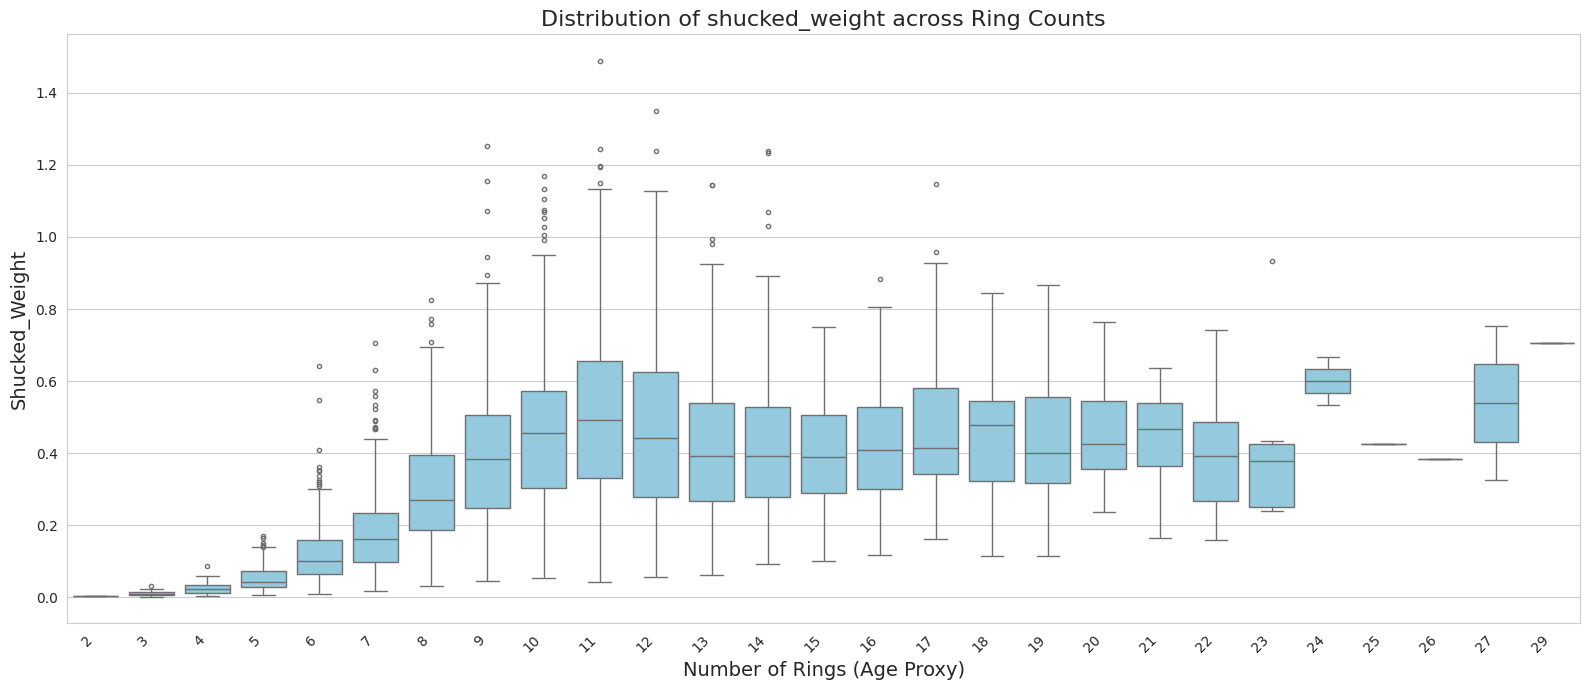

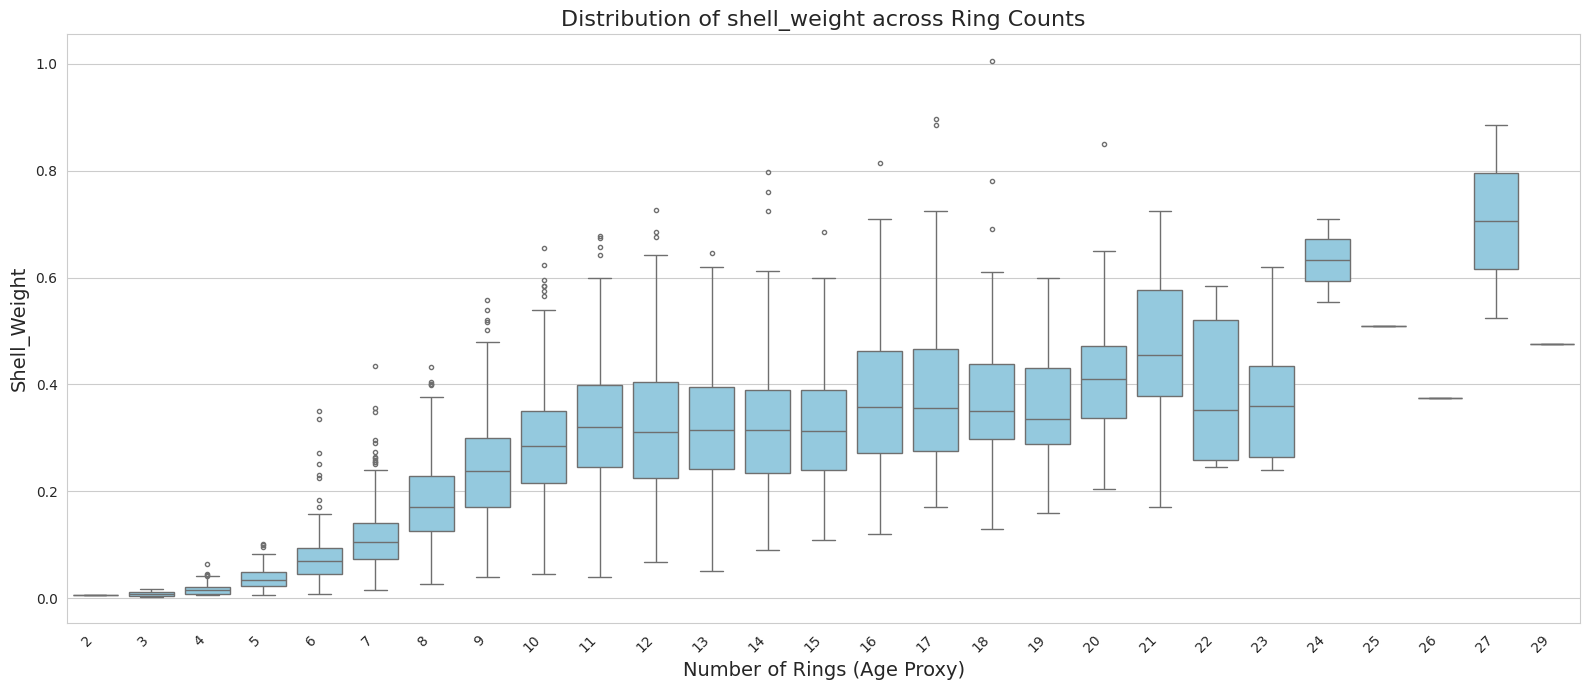

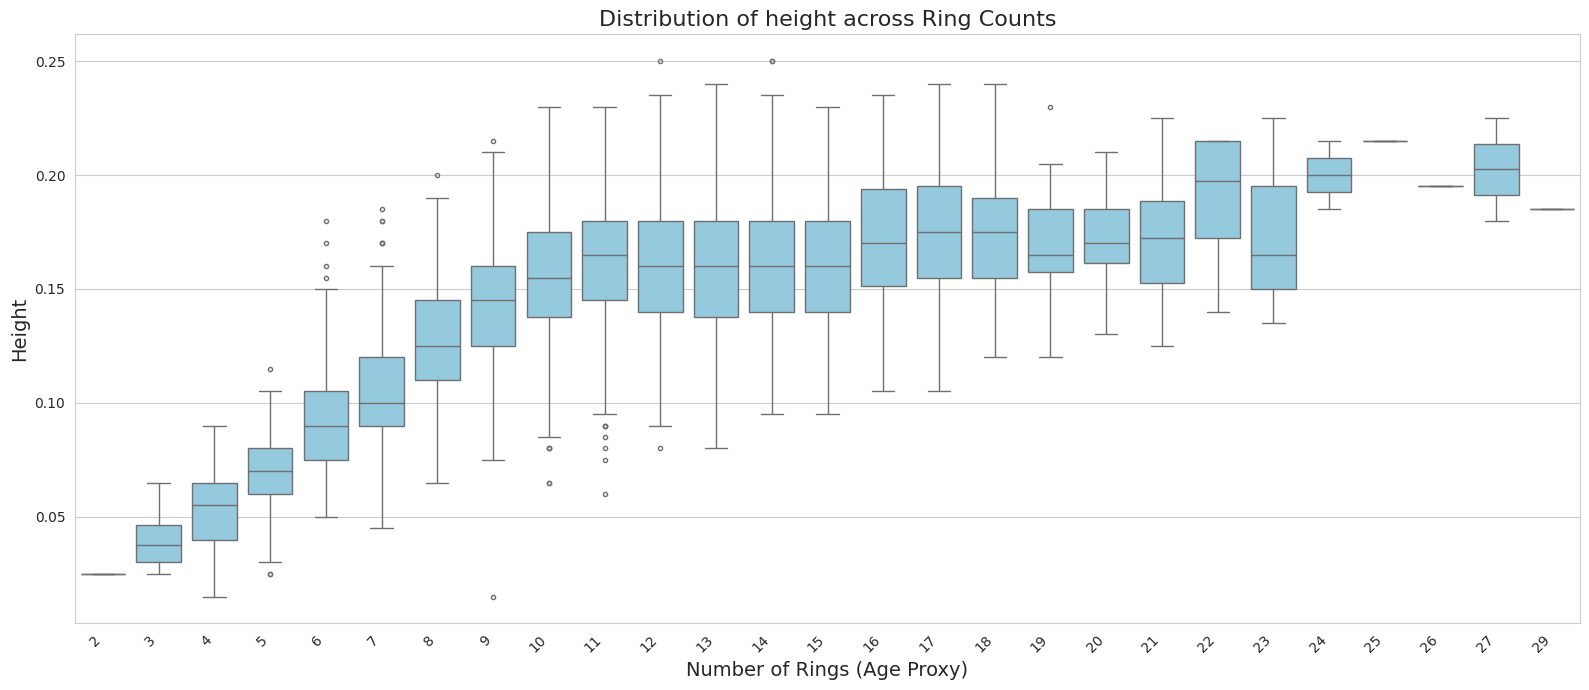

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = ['shucked_weight', 'shell_weight', 'height']


for feature in features_to_plot:
    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 7))
    sns.boxplot(
        x='rings',
        y=feature,
        data=df,
        color='skyblue',
        fliersize=3, 
        linewidth=1 
    )
    
    plt.title(f'Distribution of {feature} across Ring Counts', fontsize=16)
    plt.xlabel('Number of Rings (Age Proxy)', fontsize=14)
    plt.ylabel(f'{feature.title()}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"images/project2/{feature}_distribution_across_rings.png")

    plt.show()

